In [1]:
%pylab
%matplotlib inline

from scipy.integrate import quad
from scipy.stats import gaussian_kde
from scipy.stats import norm

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
# reference point
r = np.array([6, 6])

# Pareto-front approximation set
pf = np.array([[3, 4], [1, 5], [5, 1]])

mu = np.array([2, 3])  # mean of f1 and f2
ss = np.array([1, 1])  # variance, not std

In [37]:
def ecdf(s):
    s = np.sort(s)
    def inner(x):
        return np.sum(s <= x) / len(s)
    return inner

# Eq.(4)
def original(x, mean, variance, p):
    return (
        np.exp(-0.5 * ((x - mean[0]) ** 2 / variance[0] + (p / x - mean[1]) ** 2 / variance[1]))
        / x
    )

def get_D(L, U, loc, scale):
    return norm.cdf(U, loc, scale) - norm.cdf(L, loc, scale)

def density_in_cell(p, mean, variance, truncatedLB, truncatedUB):
    L1, L2 = truncatedLB
    U1, U2 = truncatedUB

    if L1 * U2 > U1 * L2:  # swap y_1' and y_2'
        L2, L1 = truncatedLB
        U2, U1 = truncatedUB
        mean = mean[1], mean[0]
        variance = variance[1], variance[0]
        
    D1, D2 = get_D(L1, U1, mean[0], variance[0] ** 0.5), get_D(L2, U2, mean[1], variance[1] ** 0.5)

    if L1 * L2 <= p < L1 * U2:
        alpha = L1
        belta = p / L2
    elif L1 * U2 <= p < U1 * L2:
        alpha = p / U2
        belta = p / L2
    elif U1 * L2 <= p <= U1 * U2:
        alpha = p / U2
        belta = U1
    else:
        print("error in lb and ub")

    res = quad(
        original,
        alpha,
        belta,
        args=(mean, variance, p),
        limit=1000,
        epsabs=1e-30,
        epsrel=1e-10
    )[0]
    return res / (2 * np.pi * np.sqrt(variance[0]) * np.sqrt(variance[1]) * D1 * D2)

In [61]:
L1, L2, U1, U2 = 1e-2, 1e-2, 1, 1
pvals = np.clip(10 ** np.linspace(np.log10(L1 * L2), np.log10(U1 * U2), 50), L1 * L2, U1 * U2)
rst_new = [density_in_cell(p, mu, ss, [L1, L2], [U1, U2]) for p in pvals]

In [13]:
from scipy.stats import norm

def rcond_norm(N, loc, scale, L=1, U=2):
    alpha = norm.cdf(L, loc, scale)
    beta = norm.cdf(U, loc, scale)
    Z = beta - alpha 
    return norm.ppf(np.random.rand(int(N)) * Z + alpha, loc, scale)

assert np.all(rcond_norm(1000, -0.5, 10) >= 1) and np.all(rcond_norm(1000, 20, 10) <= 2)
rcond_norm(10, mu[0], ss[0])

array([1.6218556 , 1.60489031, 1.62289157, 1.65738929, 1.0258735 ,
       1.66777016, 1.75863833, 1.04092709, 1.0908977 , 1.75199562])

In [63]:
def sample(mean, variance, lower, upper, N=1e3):
    return rcond_norm(N, mean[0], variance[0] ** 0.5, lower[0], upper[0]) * rcond_norm(N, mean[1], variance[1] ** 0.5, lower[1], upper[1])

# s = sample(mu, ss, (L1, L2), (U1, U2), int(1e6))
# density = gaussian_kde(s)

x = rcond_norm(1e7, mu[0], ss[0] ** 0.5, L1, U1)
y = rcond_norm(1e7, mu[1], ss[1] ** 0.5, L2, U2)

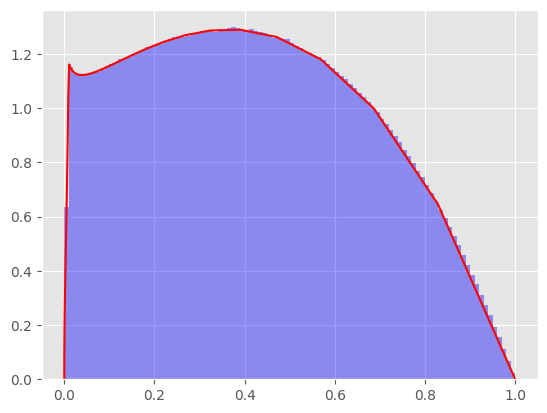

In [64]:
# n, bins, patches = plt.hist(x, 100, density=True, facecolor='g', alpha=0.4)
# n, bins, patches = plt.hist(y, 100, density=True, facecolor='r', alpha=0.4)
a = x * y
a = a[~np.isinf(a)]
n, bins, patches = plt.hist(a, 100, density=True, facecolor='b', alpha=0.4)
plt.plot(pvals, rst_new, 'r-')
# plt.semilogx()

In [65]:
f = ecdf(x * y)
v = [f(_) for _ in pvals]

In [45]:
def ecdf_from_pdf(a, mu, ss, truncatedLB, truncatedUB):
    return quad(
        density_in_cell,
        truncatedLB[0] * truncatedLB[1],
        a,
        args=(mu, ss, truncatedLB, truncatedUB),
        epsabs=1e-30,
        epsrel=1e-10,
    )[0]

In [66]:
v2 = [ecdf_from_pdf(a, mu, ss, [L1, L2], [U1, U2]) for a in pvals]

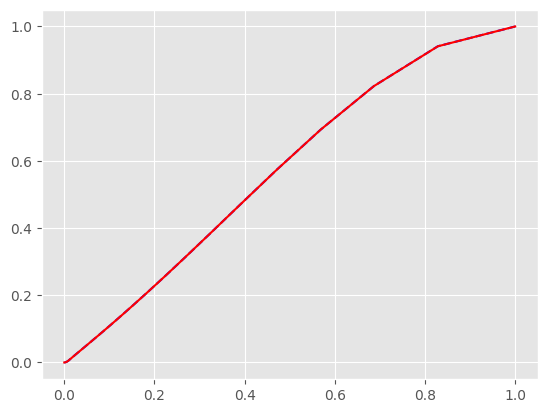

In [67]:
plt.plot(pvals, v, 'b--')
plt.plot(pvals, v2, 'r-')